# Flame Speed

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Perform a sensitivity analysis of its kinetics

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

### Import Modules

In [1]:
import cantera as ct
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['lines.linewidth'] = 2

print(f"Running Cantera version {ct.__version__}")

Running Cantera version 2.4.0


### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [2]:
# Define the gas mixture and kinetics
# In this case, we are choosing a modified version of GRI 3.0
gas = ct.Solution('input-files/gri30_noNOx.cti')

### Define flame simulation conditions

In [3]:
# Inlet temperature in kelvin and inlet pressure in pascal
To = 300
Po = 101325

# Domain width in meters
width = 0.02

# Set the inlet mixture to be stoichiometric CH4 and air 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Set options for the solver
flame.transport_model = 'Mix'
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

### Solve

The `auto` option in the solve function tries to "automatically" solve the flame by applying a few common techniques. First, the flame is solved on a sparse grid with the transport calculations set to mixture averaged. Then grid refinement is enabled, with points added according to the values of the `ratio`, `slope`, and `curve` parameters in the `set_refine_criteria` function. If the initial solve on the sparse grid fails to converge, the simulation is attempted again, but this time with the energy equation disabled. Once the simulation has been solved on the refined grid with the mixture averaged transport, Cantera enables the multicomponent transport and Soret diffusion, if they have been set by the user.

In general, it is recommended that you use the `auto` option the first time you run the solver, unless the simulation fails. On subsequent invocations of `solve`, you should not include the `auto` option (or set it to `False`).

In [4]:
flame.solve(loglevel=loglevel, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.207
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      4.318
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.247e-05      6.004
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.312e-05      6.082
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.04 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 
    to resolve C C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O C

Attempt Newton solution of steady-state problem...    success.

Problem solved on [147] point grid(s).

..............................................................................
no new points needed in flame


In [5]:
Su0 = flame.u[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0*100))
flame.show_stats()

Flame Speed is: 38.36 cm/s

Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
   11          40       1171    0.1396         44    0.4509
   18           0       1898    0.4663         78    1.7120
   25          30        875    0.3091         38    1.2516
   34           0         54    0.0276          4    0.1857
   44          10        162    0.1132          5    0.3431
   54           0         13    0.0100          2    0.1521
   69           0         14    0.0148          1    0.1091
   91           0         10    0.0155          1    0.1467
  125           0          8    0.0167          1    0.2045
  149           0          6    0.0147          1    0.2381


### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see. We expect that the solution at the boundaries of the domain will have zero gradient (in other words, that the domain width that we specified is wide enough for the flame).

#### Temperature Plot

<IPython.core.display.Javascript object>


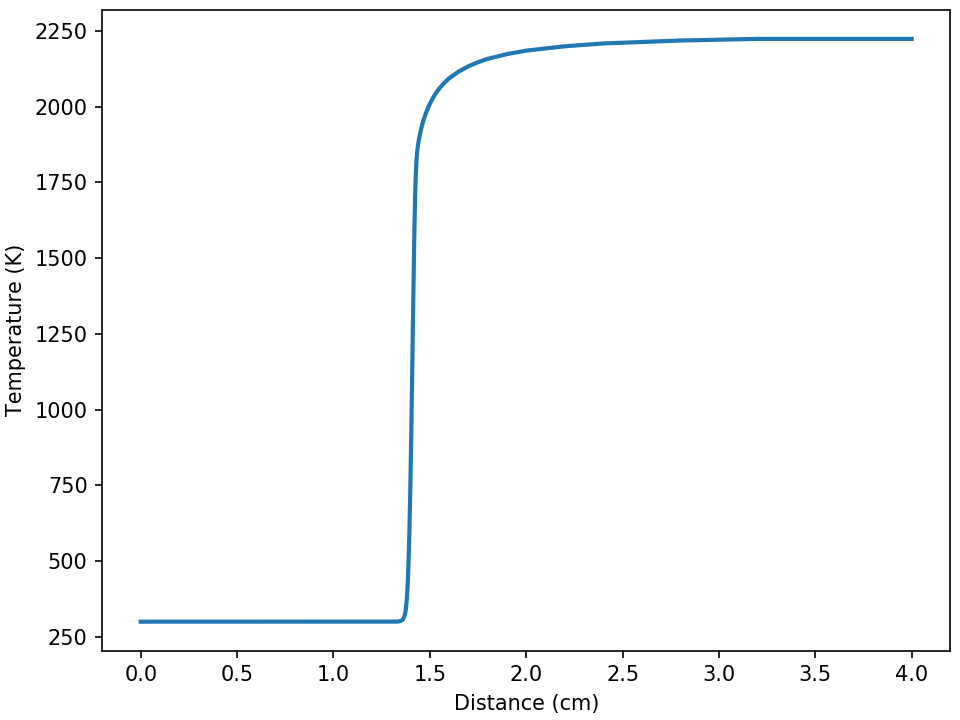

In [6]:
f, ax = plt.subplots(1, 1)
ax.plot(flame.grid*100, flame.T)
ax.set(xlabel='Distance (cm)', ylabel='Temperature (K)');
# note domain size is not what we originally set -- automatically expanded to satisfy boundary conditions

#### Major species' plot

<IPython.core.display.Javascript object>


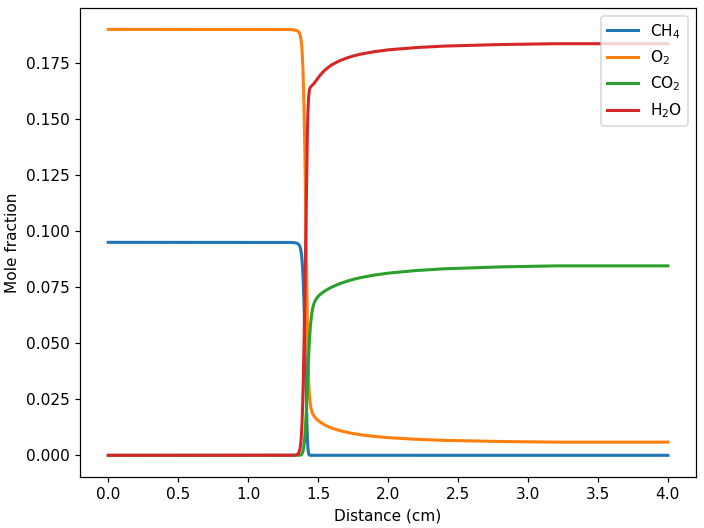

In [7]:
profile = ct.SolutionArray(gas, shape=len(flame.grid), extra={'z': flame.grid*100})
profile.TPY = flame.T, flame.P, flame.Y.T

f, ax = plt.subplots(1, 1)
ax.plot(profile.z, profile('CH4').X, label=r'CH$_4$')
ax.plot(profile.z, profile('O2').X, label=r'O$_2$')
ax.plot(profile.z, profile('CO2').X, label=r'CO$_2$')
plt.plot(profile.z, profile('H2O').X, label=r'H$_2$O')
ax.legend()
ax.set(xlabel='Distance (cm)', ylabel='Mole fraction');

## Sensitivity analysis
Compute normalized sensitivities of flame speed $S_u$ to changes in the rate coefficient $k_i$ for each reaction
$$s_i = \frac{k_i}{S_u} \frac{d S_u}{d k_i} $$

In [8]:
sens = flame.get_flame_speed_reaction_sensitivities()
# note: much slower for multicomponent / Soret

In [9]:
# Find the most important reactions:
sens_data = [(sens[i], gas.reaction_equation(i)) for i in range(gas.n_reactions)]
sens_data.sort(key=lambda item: abs(item[0]), reverse=True)
for s, eq in sens_data[:20]:
    print(f'{s: .2e}  {eq}')

 5.35e-01  H + O2 <=> O + OH
-1.62e-01  CH3 + H (+M) <=> CH4 (+M)
 1.15e-01  CO + OH <=> CO2 + H
 7.43e-02  CH3 + OH <=> CH2(S) + H2O
 7.30e-02  CH3 + HO2 <=> CH3O + OH
-7.03e-02  H + H2O + O2 <=> H2O + HO2
 5.84e-02  H2O + HCO <=> CO + H + H2O
 5.31e-02  CH3 + O => CO + H + H2
 4.53e-02  HCO + M <=> CO + H + M
-3.97e-02  H + HO2 <=> H2 + O2
-3.92e-02  CH4 + OH <=> CH3 + H2O
-3.89e-02  H + HCO <=> CO + H2
-3.80e-02  CH4 + H <=> CH3 + H2
-3.73e-02  2 CH3 (+M) <=> C2H6 (+M)
-3.42e-02  H + OH + M <=> H2O + M
-3.03e-02  HCO + O2 <=> CO + HO2
 2.79e-02  H2 + O <=> H + OH
 2.68e-02  CH2 + O2 => CO2 + 2 H
-2.07e-02  HCO + OH <=> CO + H2O
 1.90e-02  CH2(S) + O2 <=> CO + H + OH


## Solving multiple flames (parameter sweep) 

In [10]:
# Start  at one limit of the equivalence ratio range
gas.set_equivalence_ratio(0.6, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

flame = ct.FreeFlame(gas, width=width)

# Enabling pruning is important to avoid continuous increase in grid size
flame.set_refine_criteria(ratio=3, slope=0.15, curve=0.15, prune=0.1)
flame.solve(loglevel=0, refine_grid=True, auto=True)

In [11]:
phis = np.linspace(0.6, 1.8, 50)
Su = []

for phi in phis:
    gas.set_equivalence_ratio(phi, 'CH4', {'O2':1.0, 'N2':3.76})
    flame.inlet.Y = gas.Y
    flame.solve(loglevel=0)
    print(f'phi = {phi:.3f}: Su = {flame.u[0]*100:5.2f} cm/s, N = {len(flame.grid)}')
    Su.append(flame.u[0])

phi = 0.600: Su = 11.67 cm/s, N = 84
phi = 0.624: Su = 13.61 cm/s, N = 87
phi = 0.649: Su = 15.55 cm/s, N = 92
phi = 0.673: Su = 17.56 cm/s, N = 105
phi = 0.698: Su = 19.61 cm/s, N = 113
phi = 0.722: Su = 21.64 cm/s, N = 115
phi = 0.747: Su = 23.61 cm/s, N = 118
phi = 0.771: Su = 25.50 cm/s, N = 120
phi = 0.796: Su = 27.45 cm/s, N = 123
phi = 0.820: Su = 29.24 cm/s, N = 126
phi = 0.845: Su = 30.96 cm/s, N = 131
phi = 0.869: Su = 32.57 cm/s, N = 127
phi = 0.894: Su = 34.06 cm/s, N = 127
phi = 0.918: Su = 35.39 cm/s, N = 127
phi = 0.943: Su = 36.55 cm/s, N = 127
phi = 0.967: Su = 37.56 cm/s, N = 129
phi = 0.992: Su = 38.35 cm/s, N = 129
phi = 1.016: Su = 38.92 cm/s, N = 129
phi = 1.041: Su = 39.25 cm/s, N = 129
phi = 1.065: Su = 39.33 cm/s, N = 129
phi = 1.090: Su = 39.14 cm/s, N = 129
phi = 1.114: Su = 38.65 cm/s, N = 129
phi = 1.139: Su = 37.85 cm/s, N = 129
phi = 1.163: Su = 36.71 cm/s, N = 131
phi = 1.188: Su = 35.24 cm/s, N = 131
phi = 1.212: Su = 33.42 cm/s, N = 131
phi = 1.237: Su

<IPython.core.display.Javascript object>


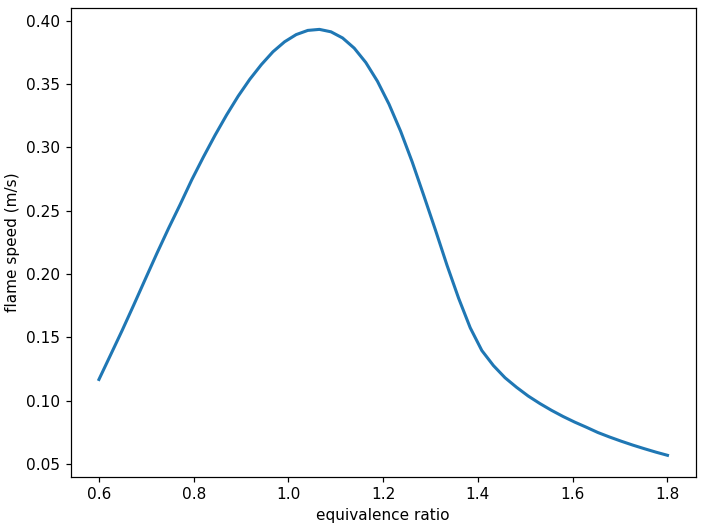

In [12]:
f, ax = plt.subplots(1, 1)
ax.plot(phis, Su)
ax.set(xlabel='equivalence ratio', ylabel='flame speed (m/s)');